### Building a simple graph and training a simple GNN 

#### Installations

In [ ]:
%pip install -r ../../requirements.txt


#### Imports

In [1]:
import pathlib
import os
import sys
from IPython.display import Image
from py2neo import Graph, Relationship, RelationshipMatcher
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

from utils.general import read_csv, df_to_json, get_year_from_title, remove_year_from_title_str
from utils_draft.movies import insert_movies, insert_movies_genres, insert_movies_years
from utils_draft.users import insert_ratings

#### Connecting to the neo4j instance

In [2]:
graph = Graph(
    "bolt://localhost:7687",
    auth=("neo4j", "admin"),
)

#### Storing the movies

##### Simple pre-process of the movies dataframe

In [3]:
movies_df = read_csv("movies")

# split the genres string to a python list
# movies_df["genres"] = movies_df["genres"].map(lambda l: l.split("|"))

# store the movie's year in a separate column
movies_df["year"] = movies_df["title"].map(lambda title: get_year_from_title(title)).astype("string")

# remove the year from the title
movies_df["title"] = movies_df["title"].map(remove_year_from_title_str)

movies_df.head()

Reading from: c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\movies_db\data_small\movies.csv


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


##### Storing them to neo4j

In [4]:
MOVIES_LIMIT = -1
movies = df_to_json(movies_df)
insert_movies(graph, movies, MOVIES_LIMIT)
insert_movies_genres(graph)
insert_movies_years(graph)

Toy Story 1995
Jumanji 1995
Grumpier Old Men 1995
Waiting to Exhale 1995
Father of the Bride Part II 1995
Heat 1995
Sabrina 1954
Tom and Huck 1995
Sudden Death 1995
GoldenEye 1995
American President, The 1995
Dracula: Dead and Loving It 1995
Balto 1995
Nixon 1995
Cutthroat Island 1995
Casino 1995
Sense and Sensibility 1995
Four Rooms 1995
Ace Ventura: When Nature Calls 1995
Money Train 1995
Get Shorty 1995
Copycat 1995
Assassins 1995
Powder 1995
Leaving Las Vegas 1995
Othello 1995
Now and Then 1995
Persuasion 2007
City of Lost Children, The (Cité des enfants perdus, La) 1995
Shanghai Triad (Yao a yao yao dao waipo qiao) 1995
Dangerous Minds 1995
Twelve Monkeys (a.k.a. 12 Monkeys) 1995
Babe 1995
Dead Man Walking 1995
It Takes Two 1995
Clueless 1995
Cry, the Beloved Country 1995
Richard III 1995
Dead Presidents 1995
Restoration 1995
Mortal Kombat 1995
To Die For 1995
How to Make an American Quilt 1995
Seven (a.k.a. Se7en) 1995
Pocahontas 1995
When Night Is Falling 1995
Usual Suspects, Th

##### Adding some relationships between the years

In [5]:
graph.run("""
    match (y1:Year), (y2:Year)
    with toInteger(y1.date) as year1, toInteger(y2.date) as year2, y1 as y1, y2 as y2
    where year1=year2-1
    merge (y1)-[next:NEXT_YEAR]-(y2)
    return year1, year2;
""")

year1,year2
1995,1996
1954,1955
2007,2008


#### Storing the users and the ratings

In [5]:
RATINGS_LIMIT = -1
ratings_df = read_csv("ratings")
ratings = df_to_json(ratings_df)
insert_ratings(graph, ratings, RATINGS_LIMIT)

Reading from: c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\movies_db\data_small\ratings.csv


##### Adding some node embeddings

In [50]:
def add_to_catalog(graph: Graph, PROJECTION_NAME: str, node_labels: list|str, relationship_name: str, properies: list|str):
    query = ("""
        CALL gds.graph.project("""+
            '"'+PROJECTION_NAME+'",'+
            "['User', 'Movie']"+""",
            {"""+
                relationship_name+
                """: {
                    properties: """+'"'+str(properies)+'"'+""",
                    orientation: "UNDIRECTED"
                }
            }
        )
    """)
    print(query)
    graph.run(query)

def remove_from_catalog(graph: Graph, PROJECTION_NAME: str):
    graph.run(f"""
        CALL gds.graph.drop("{PROJECTION_NAME}")
    """)

def add_embedding(graph: Graph, PROJECTION_NAME: str, node_labels: list|str, relationship_name: str, method, embedding_dimension: int, write_property: str, rel_weight_property: str):
    print("* Adding to graph catalog")
    add_to_catalog(graph, PROJECTION_NAME, node_labels, relationship_name, rel_weight_property)
    print("* Writting embeddings")
    method(graph, PROJECTION_NAME, str(embedding_dimension), write_property, rel_weight_property)
    print("* Removing from catalog")
    remove_from_catalog(graph, PROJECTION_NAME)

def write_fastRP_embeddings(graph, projection_name: str, embedding_dimension: int, write_property: str, relationship_weight_property: str):
    query=("""
        CALL gds.fastRP.write("""+
            '"'+projection_name+'"'+""",
            {
                embeddingDimension:""" + embedding_dimension + """,
                writeProperty: '""" + write_property + """'"""
                f""",relationshipWeightProperty: '{relationship_weight_property}'""" if relationship_weight_property else """ """ +
                """
            }
        )
    """)
    print(query)
    graph.run(query)

def add_fastRP_embeddings(graph, PROJECTION_NAME: str, nodes: list|str, relationship: str, embedding_dimension: int, write_property: str, relationship_weight_property: str):
    add_embedding(
        graph=graph,
        PROJECTION_NAME=PROJECTION_NAME,
        node_labels=nodes,
        relationship_name=relationship,
        method=write_fastRP_embeddings,
        embedding_dimension=embedding_dimension,
        write_property=write_property,
        rel_weight_property=relationship_weight_property,
    )

Add embeddings based on (m: Movie)-[b: BELONGSTO]-(y: Year)

In [52]:
add_fastRP_embeddings(
    graph=graph,
    PROJECTION_NAME="fastRP_ratings_embedding",
    nodes=["Movie", "User"],
    relationship="RATES",
    embedding_dimension=128,
    write_property="fastrp-embedding-ratings",
    relationship_weight_property="rating"
)

* Adding to graph catalog

        CALL gds.graph.project("fastRP_ratings_embedding",['User', 'Movie'],
            {RATES: {
                    properties: "rating",
                    orientation: "UNDIRECTED"
                }
            }
        )
    
* Writting embeddings

        CALL gds.fastRP.write("fastRP_ratings_embedding",
            {
                embeddingDimension:128,
                writeProperty: 'fastrp-embedding-ratings',relationshipWeightProperty: 'rating'


ClientError: [Statement.SyntaxError] Unexpected end of input: expected whitespace, '.', node labels or rel types, '[', '^', '*', '/', '%', '+', '-', "=~", IN, STARTS, ENDS, CONTAINS, IS, '=', "<>", "!=", '<', '>', "<=", ">=", AND, XOR, OR, ',' or '}' (line 5, column 95 (offset: 207))
"                writeProperty: 'fastrp-embedding-ratings',relationshipWeightProperty: 'rating'"
                                                                                               ^

Add embeddings based on (u:User)-[r: RATES]-(m: Movie)

In [47]:
add_fastRP_embeddings(
    graph=graph,
    PROJECTION_NAME="fastRP_years_embedding",
    nodes=["Movie", "Year"],
    relationship="PUBLISHED_IN",
    embedding_dimension=128,
    write_property="fastrp-embedding-dates",
    relationship_weight_property=""
)

* Adding to graph catalog

        CALL gds.graph.project("fastRP_years_embedding",['User', 'Movie'],
            {PUBLISHED_IN: {
                    properties: "",
                    orientation: "UNDIRECTED"
                }
            }
        )
    
* Writting embeddings


TypeError: 'str' object is not callable

#### Observing the Graph

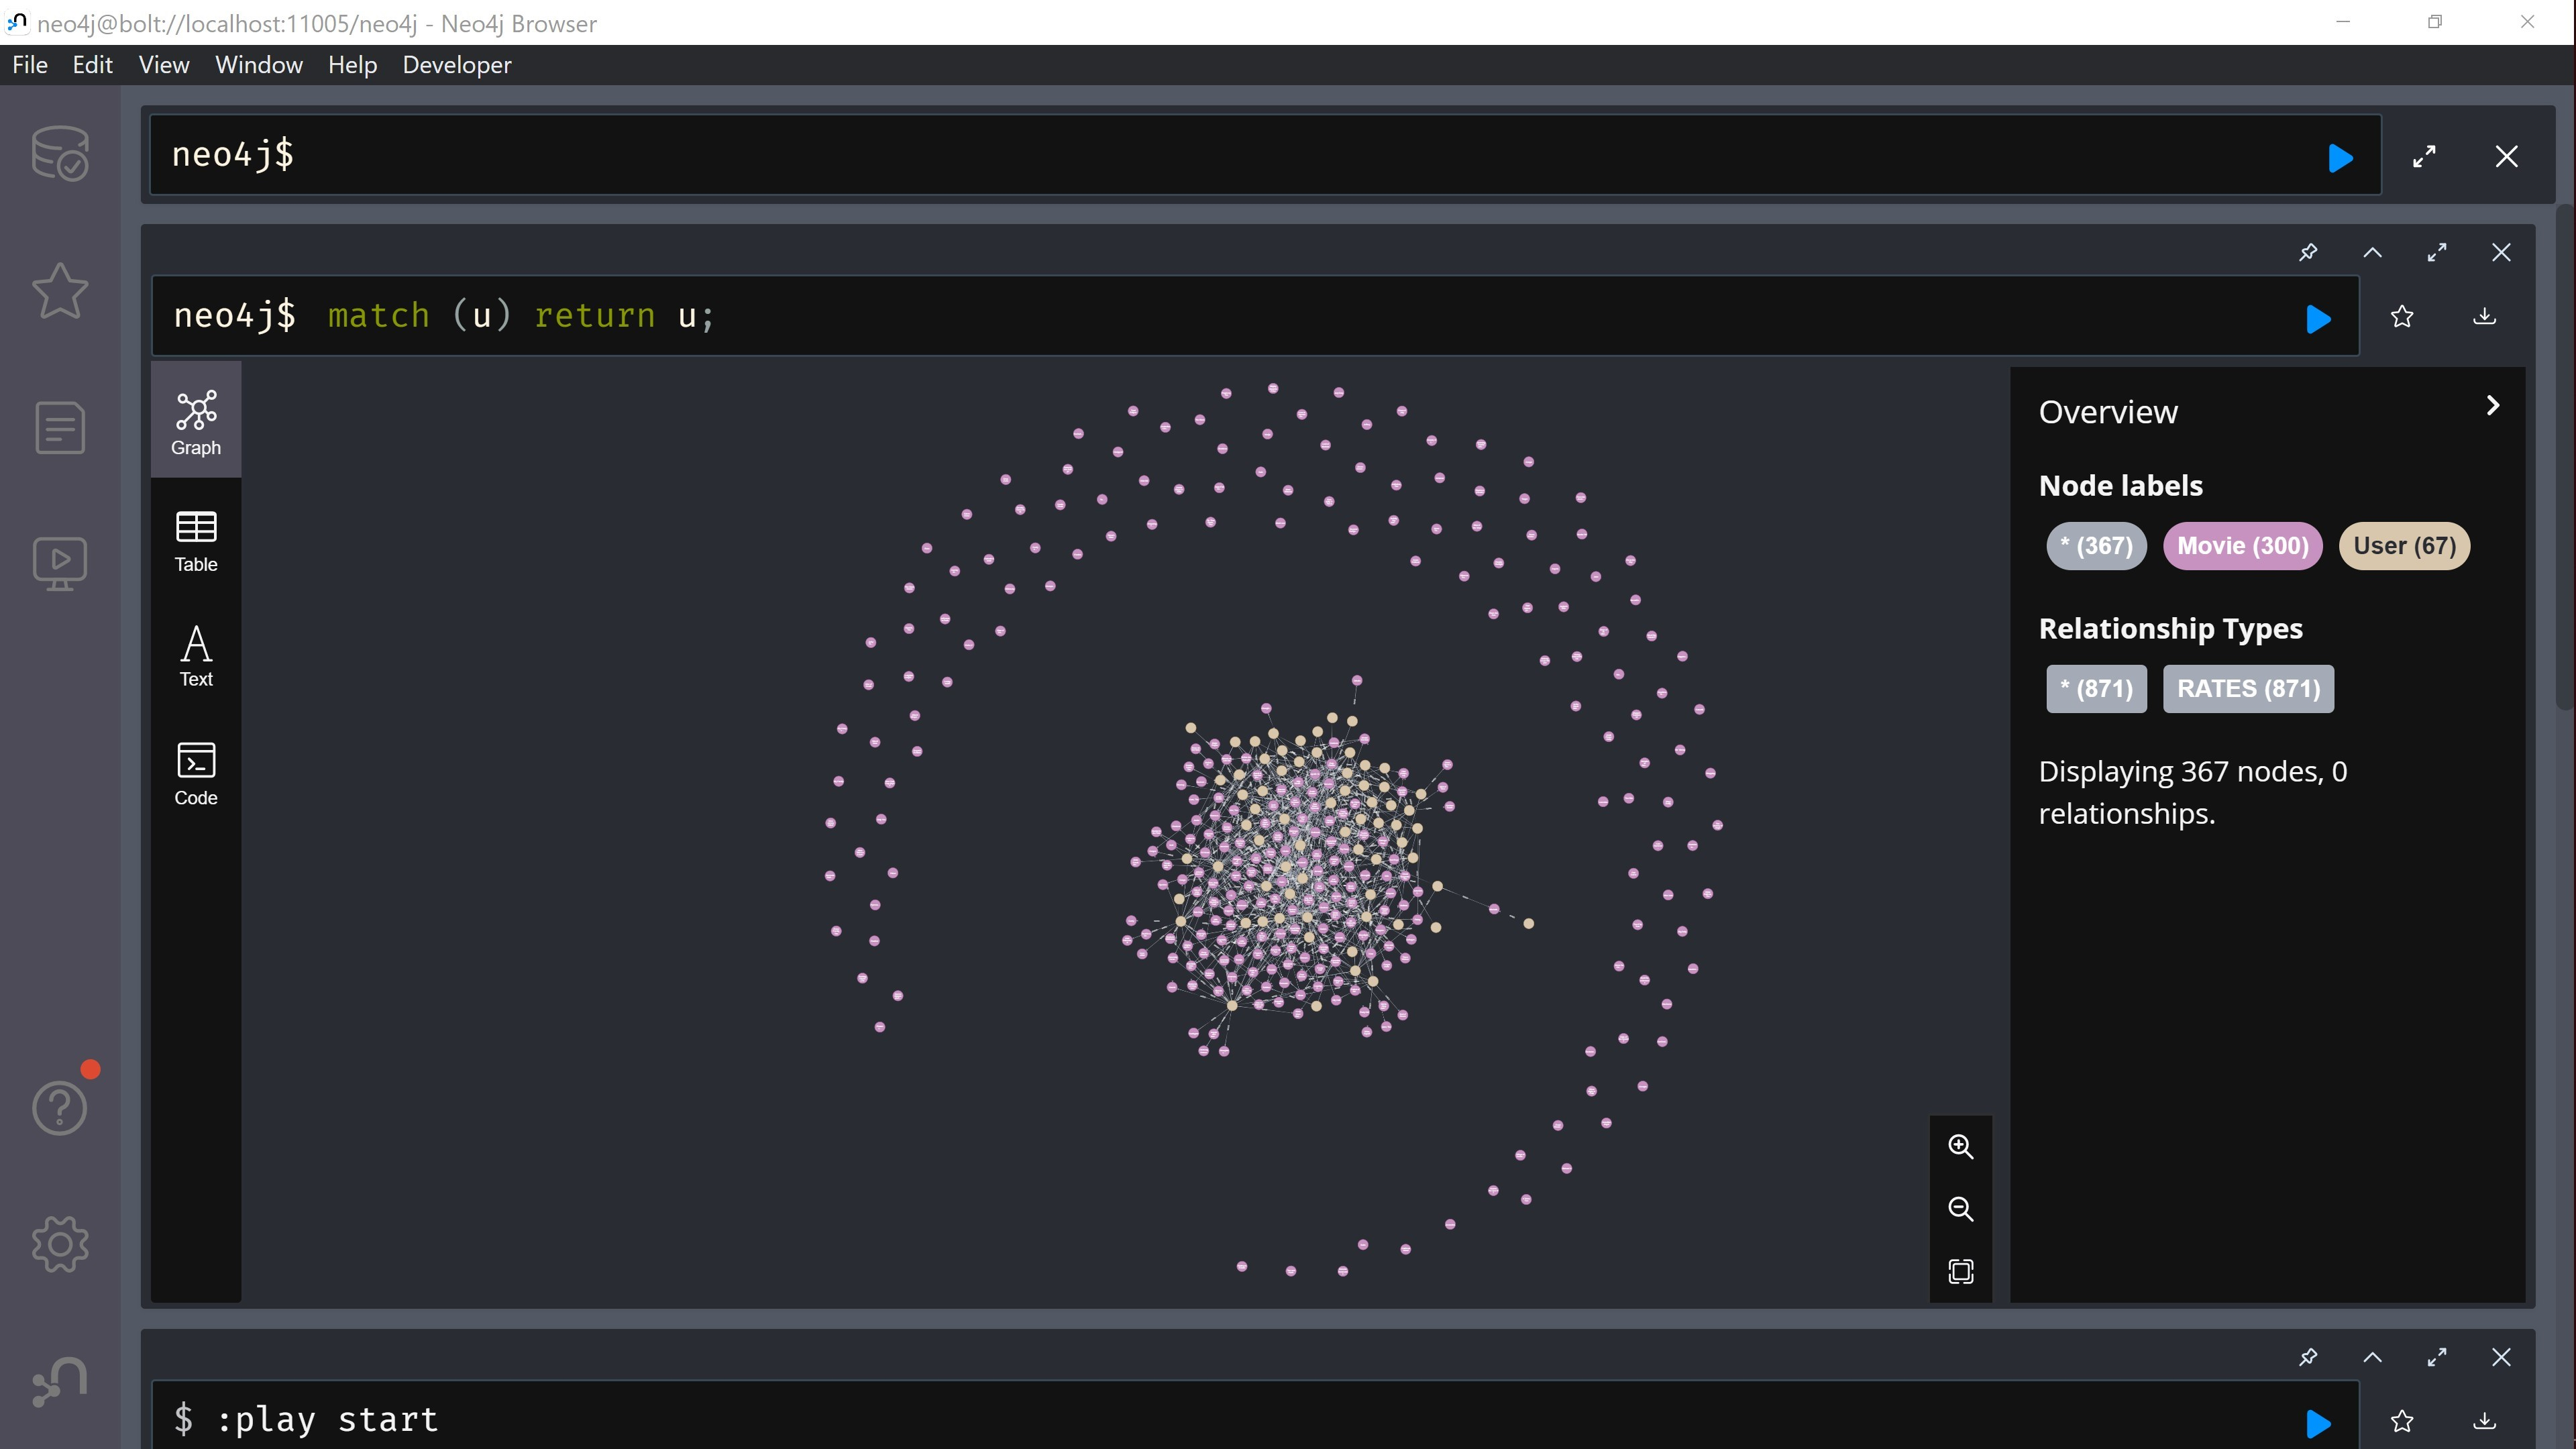

In [7]:
Image(filename='../images/simple_small_graph.jpg')


#### Trying a simple PyG GNN

##### Imports

In [46]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.nn import to_hetero
import torch.nn.functional as F
from utils_draft.pyg import load_node, load_edge, SequenceEncoder, IdentityEncoder, ListEncoder

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


##### Movies nodes

In [50]:
movies_query = """
    MATCH (m: Movie)
    return m.movieId as movieId, m.title as title, m.genres as genres, m.year as year, m['fastrp-embedding'] as fastrp
"""

movies_x, movies_mapping = load_node(
    graph=graph,
    query=movies_query,
    index_col="movieId",
    encoders={
        "title": SequenceEncoder(),
        "genres": ListEncoder(sep="|"),
        "year": SequenceEncoder(),
        "fastrp": IdentityEncoder(is_list=True)
    }
)


items: dict_items([('title', <utils.pyg.SequenceEncoder object at 0x000001BC7076E230>), ('genres', <utils.pyg.ListEncoder object at 0x000001BC53351F30>), ('year', <utils.pyg.SequenceEncoder object at 0x000001BC726CF190>), ('fastrp', <utils.pyg.IdentityEncoder object at 0x000001BC77A35930>)])


Batches:   0%|          | 0/296 [00:00<?, ?it/s]

Batches:   0%|          | 0/296 [00:00<?, ?it/s]

In [51]:
movies_x.shape

torch.Size([9460, 916])

##### Users nodes

In [53]:
users_query = """
    MATCH (u:User)-[r:RATES]-(m:Movie)
    return u.userId as userId, u.username as username, avg(r.rating) as avg_rating, count(r) as ratings, m['fastrp-embedding'] as fastrp;
"""

users_x, users_mapping = load_node(
    graph=graph,
    query=users_query,
    index_col="userId",
    encoders={
        # "avg_rating": IdentityEncoder(dtype=torch.float16),
        # "ratings": IdentityEncoder(dtype=torch.int64),
        "fastrp": IdentityEncoder(is_list=True)
    }
)


items: dict_items([('fastrp', <utils.pyg.IdentityEncoder object at 0x000001BC7076D000>)])


In [54]:
users_x.shape

torch.Size([93196, 128])

##### Ratings edges

In [55]:
ratings_query = """
    MATCH (u:User)-[r:RATES]-(m:Movie)
    return u.userId as userId, r.rating as rating, r.datetime as datetime, m.movieId as movieId;
"""

edge_index, edge_label = load_edge(
    graph=graph,
    query=ratings_query,
    src_index_col="userId",
    src_mapping=users_mapping,
    dst_index_col="movieId",
    dst_mapping=movies_mapping,
    encoders={
        "rating": IdentityEncoder(dtype=torch.long),
        # "datetime": IdentityEncoder(dtype=torch.long),
    }
)

In [56]:
edge_index.shape

torch.Size([2, 96150])

##### Building the dataset

In [57]:
data = HeteroData()

data["user"].x = users_x
data["movie"].x = movies_x

data["user", "reviews", "movie"].edge_index = edge_index
data["user", "reviews", "movie"].edge_label = edge_label
data.to(device, non_blocking=True)
print(data)

HeteroData(
  user={ x=[93196, 128] },
  movie={ x=[9460, 916] },
  (user, reviews, movie)={
    edge_index=[2, 96150],
    edge_label=[96150]
  }
)


In [58]:
data = ToUndirected()(data)
del data["movie", "rev_reviews", "user"].edge_label

transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[("user", "reviews", "movie")],
    rev_edge_types=[("movie", "rev_reviews", "user")],
)
train_data, val_data, test_data = transform(data)

In [59]:
train_data

HeteroData(
  user={ x=[93196, 128] },
  movie={ x=[9460, 916] },
  (user, reviews, movie)={
    edge_index=[2, 76920],
    edge_label=[76920],
    edge_label_index=[2, 76920]
  },
  (movie, rev_reviews, user)={ edge_index=[2, 76920] }
)

In [60]:
test_data

HeteroData(
  user={ x=[93196, 128] },
  movie={ x=[9460, 916] },
  (user, reviews, movie)={
    edge_index=[2, 86535],
    edge_label=[9615],
    edge_label_index=[2, 9615]
  },
  (movie, rev_reviews, user)={ edge_index=[2, 86535] }
)

In [61]:
val_data

HeteroData(
  user={ x=[93196, 128] },
  movie={ x=[9460, 916] },
  (user, reviews, movie)={
    edge_index=[2, 76920],
    edge_label=[9615],
    edge_label_index=[2, 9615]
  },
  (movie, rev_reviews, user)={ edge_index=[2, 76920] }
)

##### Balancing the reviews

In [62]:
torch.bincount(edge_label)

tensor([ 1314,  4425, 12501, 31547, 33742, 12621])

In [63]:
# We have an unbalanced dataset with many labels for rating 3 and 4, and very
# few for 0 and 1. Therefore we use a weighted MSE loss.

weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight

def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

##### Training

In [64]:
def train(model, train_data):
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.collect('x'), train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.collect('x'), data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)


In [80]:
layer_names = ["SAGE"]
# layer_names = ["SAGE", "GAT", "Transformer", "GraphConv"]
GNN_num_layers = [6]
# GNN_num_layers = [6, 8]
GNN_hidden_channels = [32]
# GNN_hidden_channels = [32, 64]
GNN_dropout = [0.1]
GNN_skip_connections = [True]

DECODER_num_layers = [3]
# DECODER_num_layers = [3, 4]
DECODER_hidden_channels = [32]
# DECODER_hidden_channels = [32, 64]

EPOCHS=500

In [81]:
from utils.gnn_simple import GNNEncoder, EdgeDecoder

class Model(torch.nn.Module):
    def __init__(self, gnn_layer_name, gnn_num_layers, gnn_in_channels, gnn_hidden_channels, gnn_out_channels, gnn_dropout, gnn_skip_connections, decoder_num_layers, decoder_hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(
            layer_name=gnn_layer_name,
            num_layers=gnn_num_layers,
            hidden_channels=gnn_hidden_channels,
            out_channels=gnn_out_channels,
            dropout=gnn_dropout,
            skip_connections=gnn_skip_connections,
        )
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(
            hidden_channels=decoder_hidden_channels,
            num_layers=decoder_num_layers,
        )

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [82]:
import itertools
import json

models_params = itertools.product(layer_names, GNN_num_layers, GNN_hidden_channels, GNN_dropout, GNN_skip_connections, DECODER_num_layers, DECODER_hidden_channels)

for model_params in models_params:
    specs = "_".join(str(param) for param in model_params)
    print("Model:", specs)
    
    model = Model(
        gnn_layer_name=model_params[0],
        gnn_num_layers=model_params[1],
        gnn_in_channels=-1,
        gnn_hidden_channels=model_params[2],
        gnn_out_channels=32,
        gnn_dropout=model_params[3],
        gnn_skip_connections=model_params[4],
        decoder_num_layers=model_params[5],
        decoder_hidden_channels=model_params[6],
    ).to(device)

    results = {
        "loss": [],
        "train_loss": [],
        "val_loss": [],
        "test_loss": [],
    }

    # Due to lazy initialization, we need to run one model step so the number
    # of parameters can be inferred:
    with torch.no_grad():
        model.encoder(train_data.collect('x'), train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(1, EPOCHS):
        loss = train(model, train_data)
        train_rmse = test(model, train_data)
        val_rmse = test(model, val_data)
        test_rmse = test(model, test_data)
        
        results["loss"].append(loss)
        results["train_loss"].append(train_rmse)
        results["val_loss"].append(val_rmse)
        results["test_loss"].append(test_rmse)

        if not epoch%5:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
                f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    
    output_path = os.path.join("..", "results", specs+".json")
    f = open(output_path, "w")
    f.write(json.dumps(results, indent=2))
    f.close()
    

Model: SAGE_6_32_0.1_True_3_32
Epoch: 005, Loss: 6.3779, Train: 1.1225, Val: 1.1649, Test: 1.1447
Epoch: 010, Loss: 6.8670, Train: 1.1495, Val: 1.1892, Test: 1.1618
Epoch: 015, Loss: 7.5717, Train: 1.9846, Val: 2.0078, Test: 2.0211
Epoch: 020, Loss: 6.7575, Train: 1.2183, Val: 1.2948, Test: 1.2766
Epoch: 025, Loss: 6.4202, Train: 1.5349, Val: 1.5543, Test: 1.5910
Epoch: 030, Loss: 6.0647, Train: 1.5353, Val: 1.5168, Test: 1.5509
Epoch: 035, Loss: 6.0291, Train: 1.2446, Val: 1.2955, Test: 1.2779
Epoch: 040, Loss: 5.9540, Train: 1.4812, Val: 1.5043, Test: 1.4885
Epoch: 045, Loss: 5.8417, Train: 1.3565, Val: 1.3871, Test: 1.4143
Epoch: 050, Loss: 5.6890, Train: 1.2588, Val: 1.3069, Test: 1.2966
Epoch: 055, Loss: 5.6123, Train: 1.2811, Val: 1.3045, Test: 1.3185
Epoch: 060, Loss: 5.4456, Train: 1.2718, Val: 1.2690, Test: 1.3141
Epoch: 065, Loss: 5.3613, Train: 1.3752, Val: 1.4009, Test: 1.3871
Epoch: 070, Loss: 5.3114, Train: 1.3913, Val: 1.3888, Test: 1.4034
Epoch: 075, Loss: 5.2657, Train

##### Plot the results

###### SAGE

In [83]:
import json
import matplotlib.pyplot as plt

def plot_loss(results_path, gnn_name="SAGE", loss_name="loss"):
    results_path = os.path.join("..", "results")
    min_loss = {
        "gnn": None,
        "value": float('inf'),
        "epoch": 0,
    }
    plt.figure(figsize=(30, 10))
    plt.ylim([0, 10])
    for f in os.listdir(results_path):
        if f.lower().startswith(gnn_name.lower()):
            file = os.path.join(results_path, f)
            if os.path.isfile(file):
                with open(file, 'r') as data:
                    data = json.load(data)
                    loss = data.get(loss_name)
                    minimum = min(loss)
                    if minimum<min_loss["value"]:
                        min_loss["gnn"] = f
                        min_loss["value"] = minimum
                        min_loss["epoch"] = loss.index(minimum)
                    plt.plot(loss, label=f)
                    plt.legend()
                    plt.title(" | ".join([gnn_name, loss_name, f"min loss {round(min_loss['value'], 2)} by: {min_loss['gnn']} on epoch {min_loss['epoch']}"]))

def plot_gnn(gnn_name):
    results_path = os.path.join("..", "results")
    plot_loss(results_path, gnn_name, "loss")
    plot_loss(results_path, gnn_name, "train_loss")
    plot_loss(results_path, gnn_name, "val_loss")
    plot_loss(results_path, gnn_name, "test_loss")


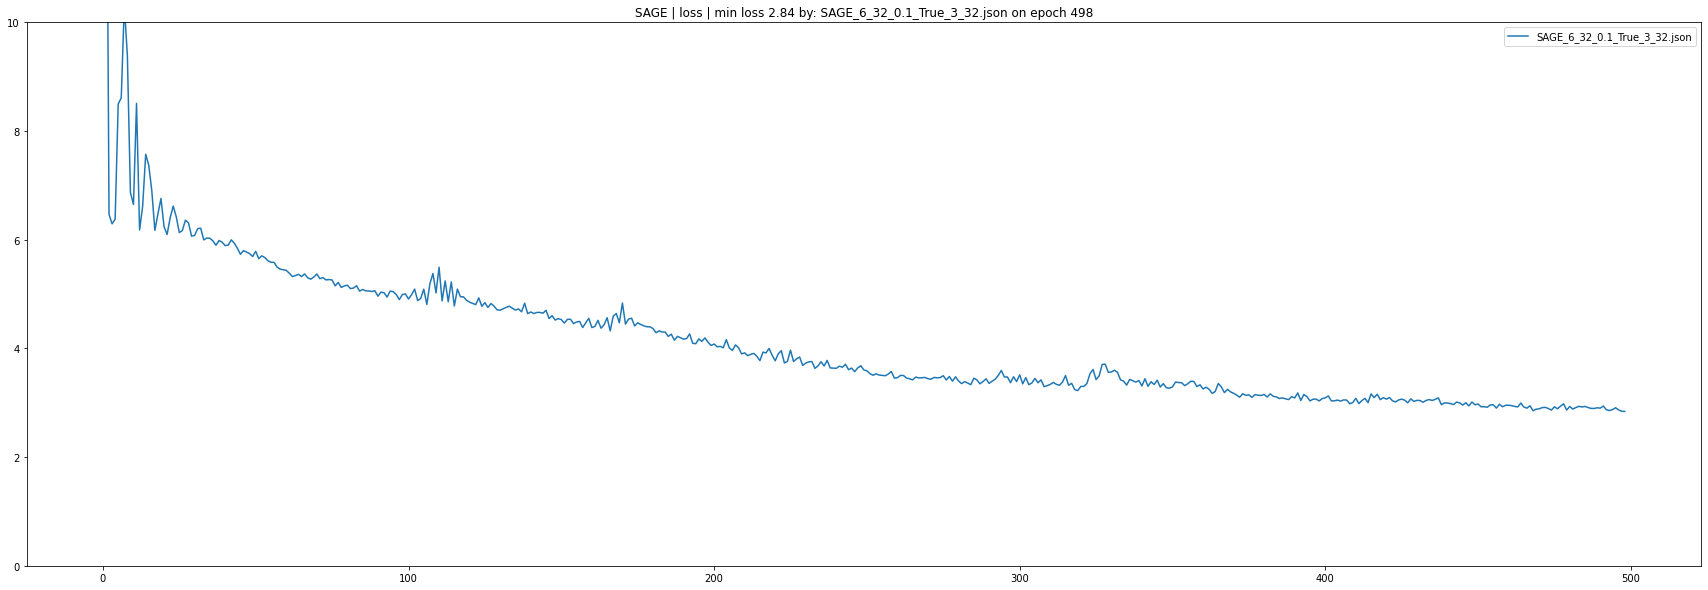

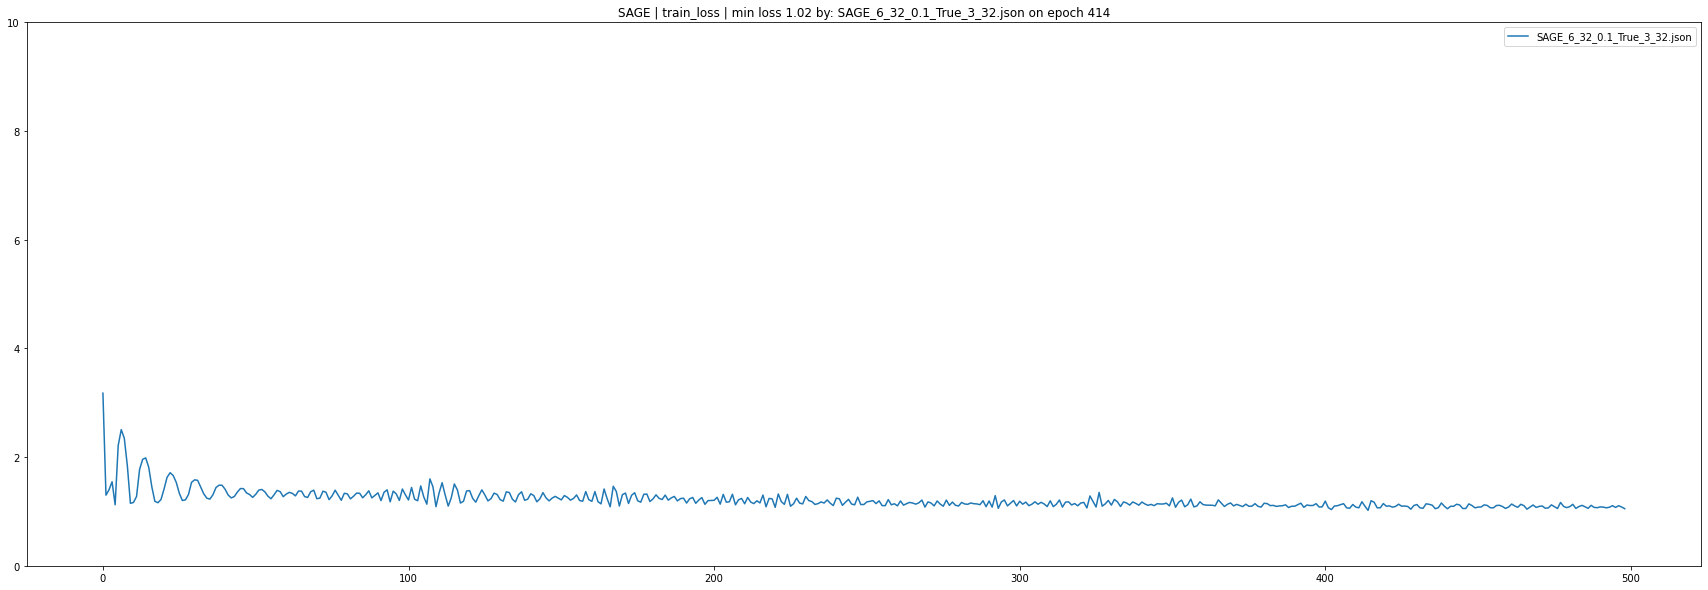

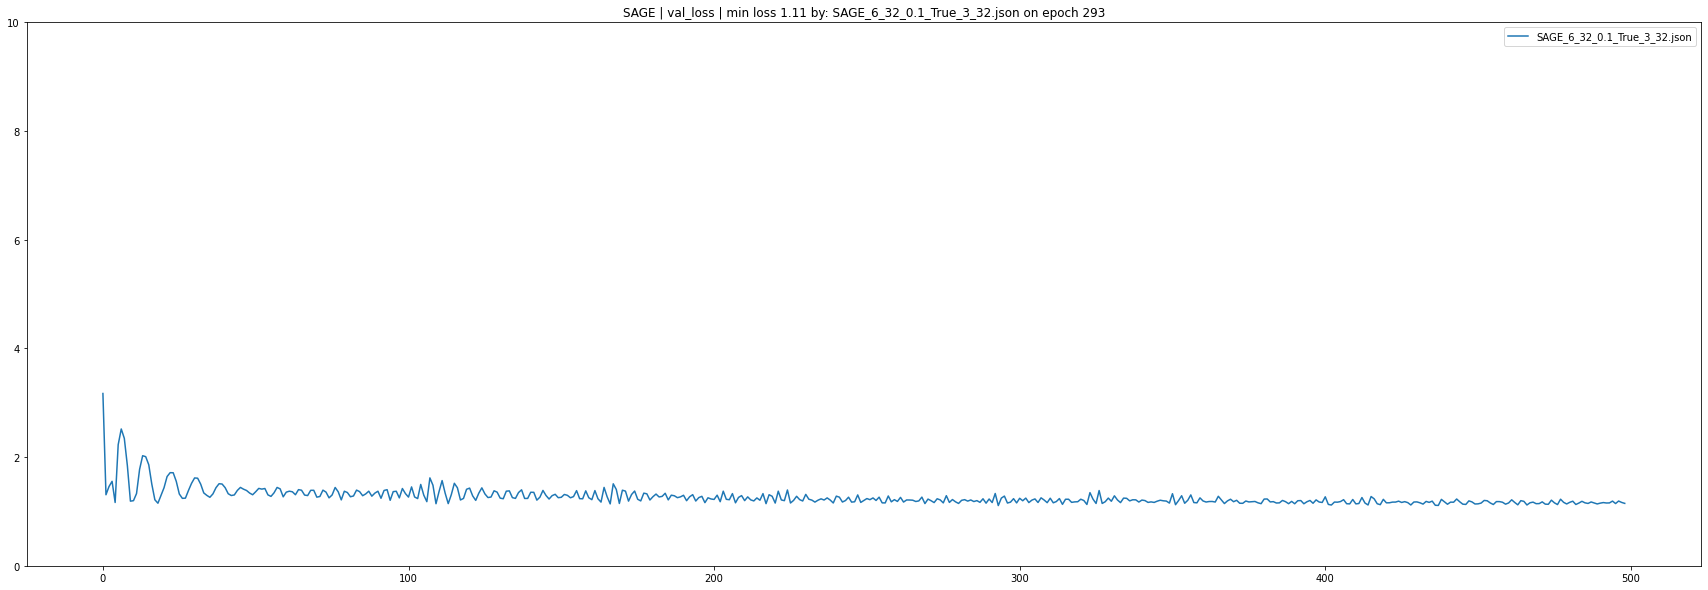

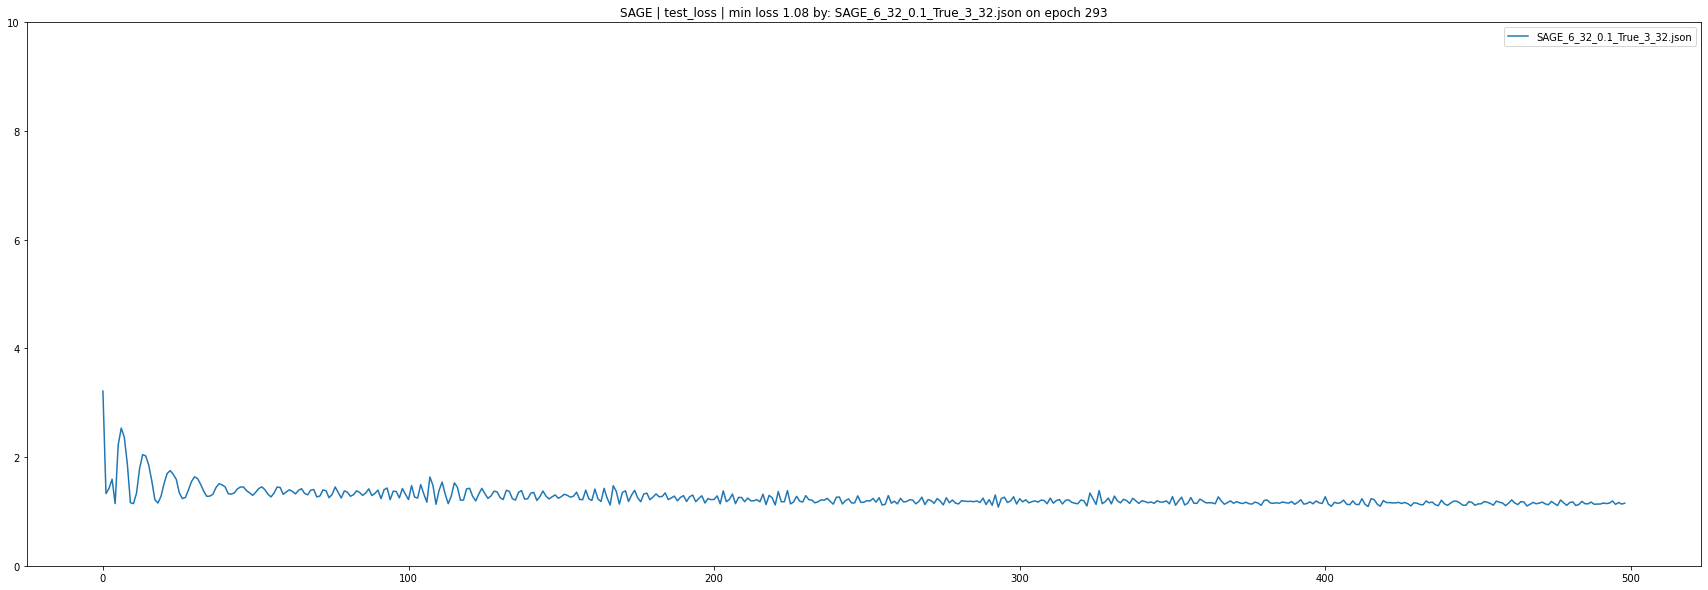

In [84]:
plot_gnn("SAGE")


##### Examining the predictions

In [ ]:
# https://towardsdatascience.com/integrate-neo4j-with-pytorch-geometric-to-create-recommendations-21b0b7bc9aa

num_movies = len(movies_mapping)
num_users = len(users_mapping)

reverse_movie_mapping = dict(zip(movies_mapping.values(),movies_mapping.keys()))
reverse_user_mapping = dict(zip(users_mapping.values(),users_mapping.keys()))

results = []

for user_id in range(0,num_users): 

    row = torch.tensor([user_id] * num_movies)
    col = torch.arange(num_movies)
    edge_label_index = torch.stack([row, col], dim=0)

    pred = model(data.x_dict, data.edge_index_dict,
                 edge_label_index)
    pred = pred.clamp(min=0, max=5)

    user_neo4j_id = reverse_user_mapping[user_id]

    mask = (pred == 5).nonzero(as_tuple=True)

    predictions = [reverse_movie_mapping[el] for el in  mask[0].tolist()[:20]]
    results.append({'user': user_neo4j_id, 'movies': predictions})

In [ ]:
def get_user_suggestions(userId: int):
    movies_ids = []
    movies = []
    for sugg in results:
        if sugg["user"] == userId:
            movies_ids = sugg["movies"]
            break
    for movie_id in movies_ids:
        movie = graph.nodes.match("Movie", movieId=movie_id).first()
        if movie:
            movies.append(movie)
    return movies

def get_user_reviews(userId: int):
    movies_ids = []
    movies = []
    relationship_matcher = RelationshipMatcher(graph)
    RATES = Relationship.type("RATES")
    user = graph.nodes.match("User", userId=userId).first()
    if user:
        reviews = list(relationship_matcher.match([user], r_type=RATES))
        movies_ids = map(lambda review: review.end_node["movieId"], reviews)
        for movie_id in movies_ids:
            movie = graph.nodes.match("Movie", movieId=movie_id).first()
            if movie:
                movies.append(movie)
        return movies
    return f"User {userId} not found"

In [ ]:
print(get_user_reviews(1))
print(get_user_suggestions(1))

[Node('Movie', genres='Drama', movieId=7937, title='Silence, The (Tystnaden)', year='1963'), Node('Movie', genres='Comedy|Drama|Romance', movieId=32591, title='Look at Me (Comme une image)', year='2004'), Node('Movie', genres='Drama|Romance', movieId=31956, title='5x2', year='2004'), Node('Movie', genres='Drama|Mystery|Romance|War', movieId=27721, title='Very Long Engagement, A (Un long dimanche de fiançailles)', year='2004'), Node('Movie', genres='Drama|Fantasy|Romance|Sci-Fi', movieId=27266, title='2046', year='2004'), Node('Movie', genres='Action|Comedy', movieId=27193, title='Taxi 2', year='2000'), Node('Movie', genres='Drama|Thriller', movieId=8973, title='Bad Education (La mala educación)', year='2004'), Node('Movie', genres='Adventure|Drama', movieId=8873, title='Motorcycle Diaries, The (Diarios de motocicleta)', year='2004'), Node('Movie', genres='Drama', movieId=8786, title='Port of Shadows (Quai des brumes)', year='1938'), Node('Movie', genres='Drama', movieId=8729, title='Sw